In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from chart_studio import plotly
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, pytz
import torch
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from numpy import log
from statsmodels.tsa.stattools import acf
import random
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
import math
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('btc.txt',sep=',',
                         index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [3]:
stock_data

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.650000,1003.080000,958.690000,998.325000,147775008
2017-01-02,998.617000,1031.390000,996.702000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2023-04-16,30315.976420,30555.537630,30157.832330,30315.355460,12854816417
2023-04-17,30317.145700,30319.196580,29275.371060,29445.044900,17872186762
2023-04-18,29449.091700,30470.302010,29154.849370,30397.552740,19480529496


In [4]:
stock_data = stock_data.drop('High', axis=1)
stock_data = stock_data.drop('Low', axis=1)
stock_data = stock_data.drop('Close', axis=1)
stock_data = stock_data.drop('Volume', axis=1)
stock_data = stock_data.rename(columns={'Open': 'Price'})
stock_data

,Price
Date,
2017-01-01,963.650000
2017-01-02,998.617000
2017-01-03,1021.599976
2017-01-04,1044.400024
2017-01-05,1156.729980
...,...
2023-04-16,30315.976420
2023-04-17,30317.145700
2023-04-18,29449.091700


In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2301 entries, 2017-01-01 to 2023-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2301 non-null   float64
dtypes: float64(1)
memory usage: 36.0 KB


In [6]:
stock_data.isnull().sum()

Price    0
dtype: int64

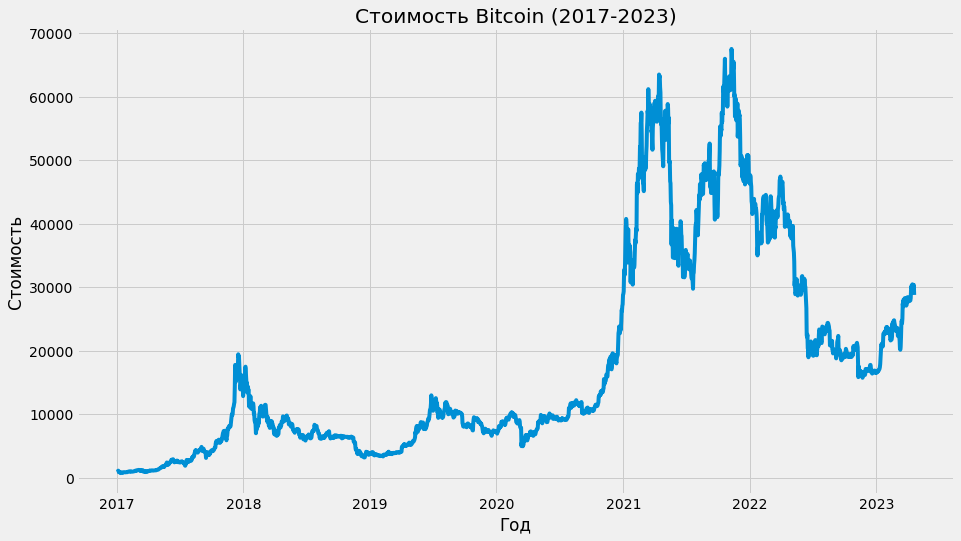

In [7]:
plt.figure(figsize=(14,8))
plt.grid(True)
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.plot(stock_data)
plt.title('Стоимость Bitcoin (2017-2023)')
plt.show()

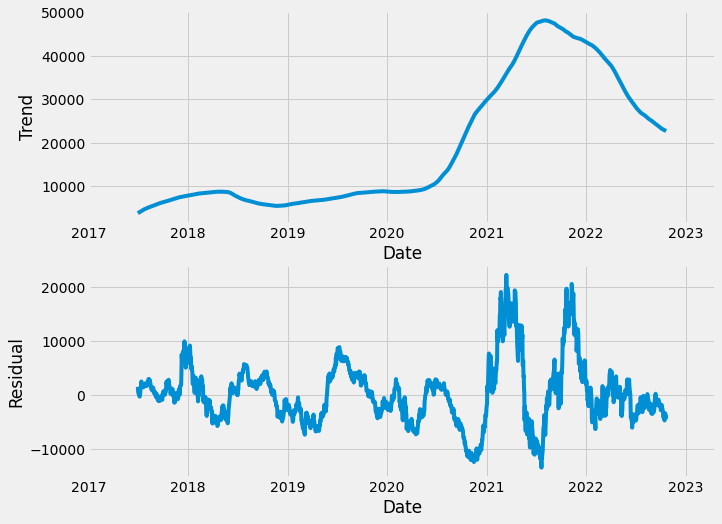

In [8]:
rcParams['figure.figsize'] = 11, 9
decomposed_data = sm.tsa.seasonal_decompose(stock_data,freq=360)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
decomposed_data.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
decomposed_data.resid.plot(ax=ax2)
ax2.set_ylabel('Residual')
plt.show()

### Тест стационарности и преобразование

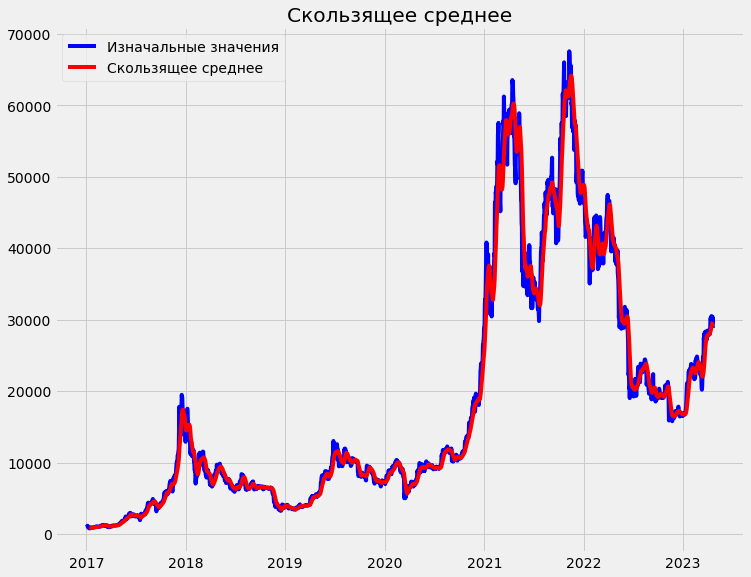

Результаты теста Дики — Фуллера
Статистический критерий         -1.655783
p-value                          0.454026
Число лагов                     27.000000
Число наблюдений              2273.000000
Критическое значение (1%)       -3.433230
Критическое значение (5%)       -2.862812
Критическое значение (10%)      -2.567447
dtype: float64


In [9]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.plot(timeseries, color='blue',label='Изначальные значения')
    plt.plot(rolmean, color='red', label='Скользящее среднее')
    plt.legend(loc='best')
    plt.title('Скользящее среднее')
    plt.show(block=False)
    
    print("Результаты теста Дики — Фуллера")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Статистический критерий','p-value','Число лагов','Число наблюдений'])
    for key,values in adft[4].items():
        output['Критическое значение (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data)

Мы видим, что p-значение больше 0,05, поэтому мы не можем отвергнуть нулевую гипотезу. Кроме того, тестовая статистика больше критического значения, поэтому данные нестационарны.


Поэтому необходимо привести ряд к стационарности

In [10]:
# дифференцирование временного ряда
ts_diff = stock_data.diff().dropna()

# логарифмирование временного ряда
ts_log = np.log(stock_data)

# дифференцирование и логарифмирование временного ряда
ts_diff_log = np.log(ts_diff).dropna()

In [11]:
result = adfuller(ts_diff_log)
print('ADF: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF: -2.9948411094806087
p-value: 0.03537899248935923


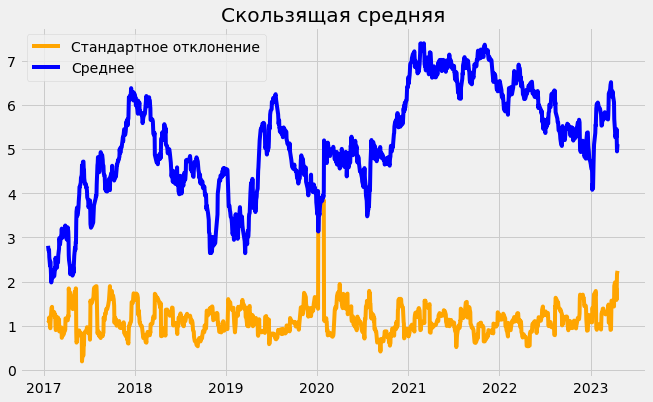

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
moving_avg = ts_diff_log.rolling(12).mean()
std_dev = ts_diff_log.rolling(12).std()
#plt.legend(loc='best')
plt.title('Скользящая средняя')
plt.plot(std_dev, color ="orange", label = "Стандартное отклонение")
plt.plot(moving_avg, color="blue", label = "Среднее")
plt.legend()
plt.show()

# Разделение выборки и построение ARIMA

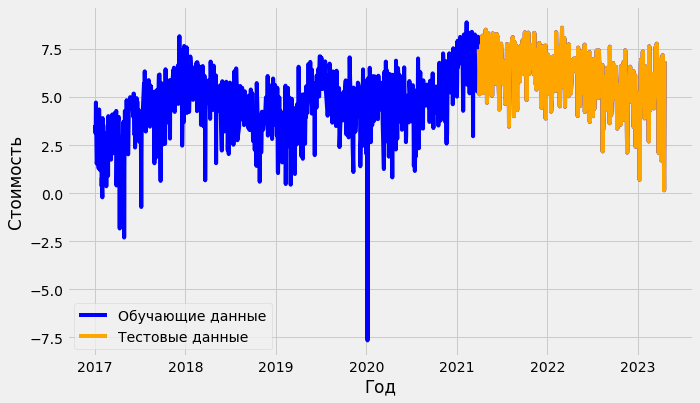

In [13]:
train_data, test_data = ts_diff_log[3:int(len(ts_diff_log)*0.7)], ts_diff_log[int(len(ts_diff_log)*0.7):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.plot(ts_diff_log, 'blue', label='Обучающие данные')
plt.plot(test_data, 'orange', label='Тестовые данные')
plt.legend()

Подбор параметров при помощи auto_arima

In [14]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
#model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5119.958, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3328.528, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4430.221, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3123.782, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3028.938, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2872.148, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2870.513, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2868.587, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2870.510, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4076.103, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2872.442, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2866.490, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3146.946, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3078.567, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

In [15]:
model = ARIMA(train_data, order=(1,0,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  851
Model:                     ARMA(1, 1)   Log Likelihood               -1429.245
Method:                       css-mle   S.D. of innovations              1.296
Date:                Tue, 16 May 2023   AIC                           2866.490
Time:                        19:43:32   BIC                           2885.475
Sample:                             0   HQIC                          2873.762
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.6441      0.683      6.804      0.000       3.306       5.982
ar.L1.Price     0.9935      0.005    194.048      0.000       0.983       1.004
ma.L1.Price    -0.8843      0.018    -48.834    

In [16]:
len(test_data)

366

In [17]:
fc, se, conf = fitted.forecast(366, alpha=0.05)

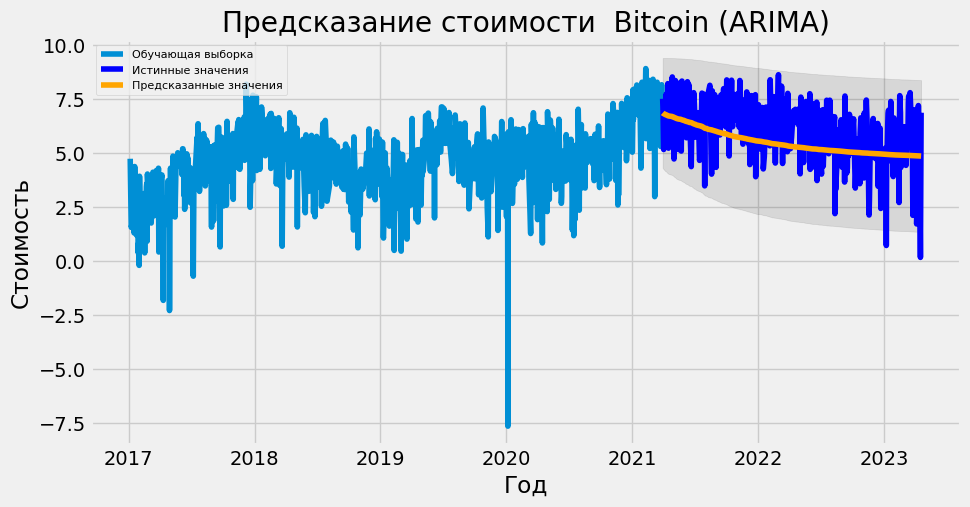

In [18]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Обучающая выборка')
plt.plot(test_data, color = 'blue', label='Истинные значения')
plt.plot(fc_series, color = 'orange',label='Предсказанные значения')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Предсказание стоимости  Bitcoin (ARIMA)')
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
fc_reshape =fc.reshape(366,1)

In [20]:
mae = mean_absolute_error(test_data, fc_reshape)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_reshape))
print('RMSE: '+str(rmse))
mean_obs = test_data.mean()
si = rmse/mean_obs
print('SI: '+str(si))
mape = np.mean(np.abs(fc_reshape - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MAE: 1.1760656968115024
RMSE: 1.4017649181701102
SI: Price    0.228532
dtype: float64
MAPE: Price    0.296231
dtype: float64


# Построение LSTM

In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Истинные значения')
    plt.plot(predicted, color='blue',label='Предсказанные значения')
    plt.title('Предсказание стоимости Bitcoin')
    plt.xlabel('Год')
    plt.ylabel('Стоимость')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data_nn = pd.read_csv('btc.txt',sep=',',
                         index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data_nn = stock_data_nn.rename(columns={'Open': 'Price'})
stock_data_nn

,Price,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.650000,1003.080000,958.690000,998.325000,147775008
2017-01-02,998.617000,1031.390000,996.702000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2023-04-16,30315.976420,30555.537630,30157.832330,30315.355460,12854816417
2023-04-17,30317.145700,30319.196580,29275.371060,29445.044900,17872186762
2023-04-18,29449.091700,30470.302010,29154.849370,30397.552740,19480529496


In [4]:
training_set = stock_data_nn[:'2021-12-06'].iloc[:,1:2].values
test_set = stock_data_nn['2021-12-07':].iloc[:,1:2].values

In [5]:
len(training_set),len(test_set)

(1801, 500)

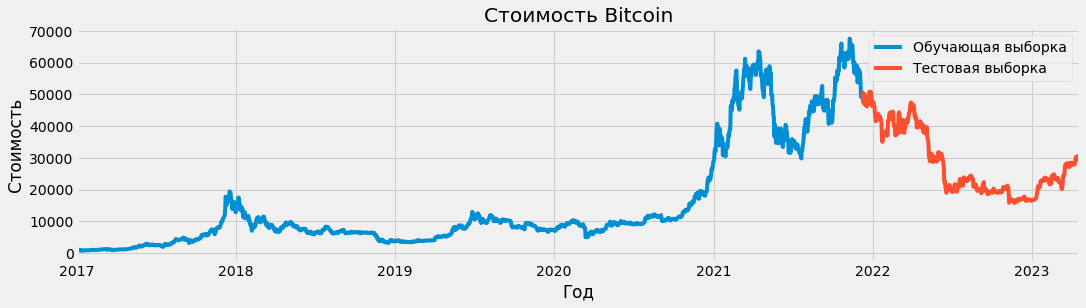

In [6]:
stock_data_nn["Price"][:'2021-12-06'].plot(figsize=(16,4),legend=True)
stock_data_nn["Price"]['2021-12-07':].plot(figsize=(16,4),legend=True)
plt.legend(['Обучающая выборка','Тестовая выборка'])
plt.title('Стоимость Bitcoin')
plt.xlabel('Год')
plt.ylabel('Стоимость')
plt.show()

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
X_train = []
y_train = []
for i in range(60,1801 ):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [101]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1 , activation='tanh'))

# Compiling the RNN
regressor.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
# Fitting to the training set
history = regressor.fit(X_train,y_train, epochs=200,batch_size=64)
loss_values = history.history['loss']

Epoch 1/200
28/28 [==============================] - 4s 47ms/step - loss: 0.0170
Epoch 2/200
28/28 [==============================] - 1s 47ms/step - loss: 0.0033
Epoch 3/200
28/28 [==============================] - 1s 47ms/step - loss: 0.0027
Epoch 4/200
28/28 [==============================] - 1s 48ms/step - loss: 0.0025
Epoch 5/200
28/28 [==============================] - 1s 48ms/step - loss: 0.0022
Epoch 6/200
28/28 [==============================] - 1s 48ms/step - loss: 0.0022
Epoch 7/200
28/28 [==============================] - 1s 47ms/step - loss: 0.0020
Epoch 8/200
28/28 [==============================] - 1s 49ms/step - loss: 0.0020
Epoch 9/200
28/28 [==============================] - 1s 48ms/step - loss: 0.0022
Epoch 10/200
28/28 [==============================] - 1s 47ms/step - loss: 0.0021
Epoch 11/200
28/28 [==============================] - 1s 48ms/step - loss: 0.0019
Epoch 12/200
28/28 [==============================] - 1s 47ms/step - loss: 0.0018
Epoch 13/200
28/28 [=====

28/28 [==============================] - 1s 47ms/step - loss: 5.0474e-04
Epoch 193/200
28/28 [==============================] - 1s 47ms/step - loss: 5.5344e-04
Epoch 194/200
28/28 [==============================] - 1s 48ms/step - loss: 4.6142e-04
Epoch 195/200
28/28 [==============================] - 1s 47ms/step - loss: 4.1700e-04
Epoch 196/200
28/28 [==============================] - 1s 47ms/step - loss: 5.1190e-04
Epoch 197/200
28/28 [==============================] - 1s 46ms/step - loss: 4.9498e-04
Epoch 198/200
28/28 [==============================] - 1s 46ms/step - loss: 4.4528e-04
Epoch 199/200
28/28 [==============================] - 1s 48ms/step - loss: 4.3593e-04
Epoch 200/200
28/28 [==============================] - 1s 47ms/step - loss: 4.7632e-04


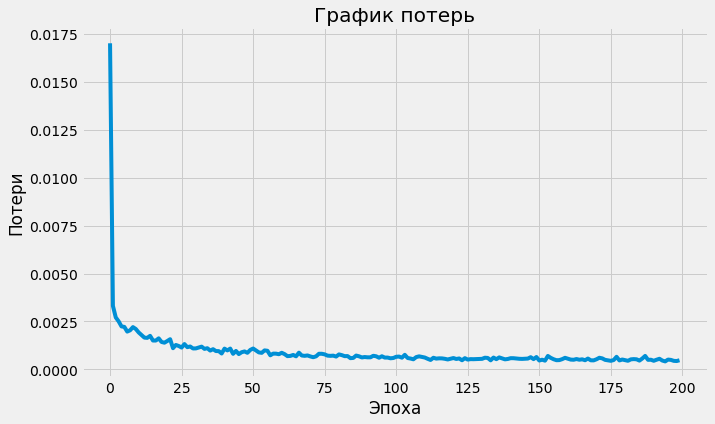

In [102]:
plt.plot(loss_values)
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.show()

In [103]:
dataset_total = pd.concat((stock_data_nn["Price"][:'2021-12-06'],stock_data_nn["Price"]['2021-12-07':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [104]:
X_test = []
for i in range(60,560):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

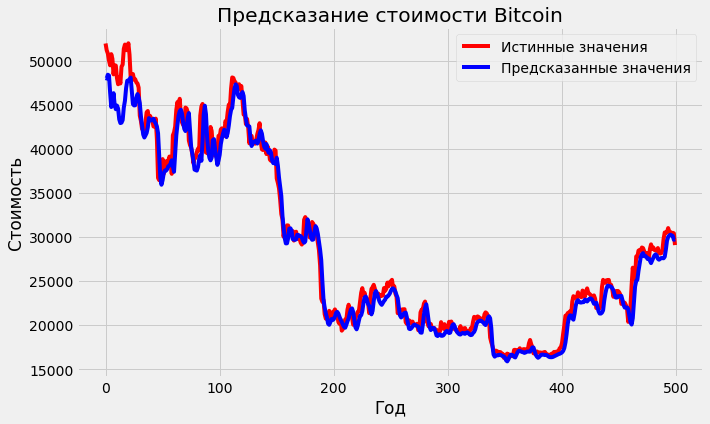

In [105]:
plot_predictions(test_set,predicted_stock_price)

In [106]:
def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

In [107]:
mae = mean_absolute_error(test_set, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print('RMSE: '+str(rmse))
mn = test_set.mean()
si = (rmse/mn)*100
print('SI:' + toFixed(si, 2) + "%")
mape = (np.mean(np.abs(predicted_stock_price - test_set)/np.abs(test_set)))*100
print('MAPE:' + toFixed(si, 2) + "%")

MAE: 1129.3858679581256
RMSE: 1626.3953695401162
SI:5.63%
MAPE:5.63%


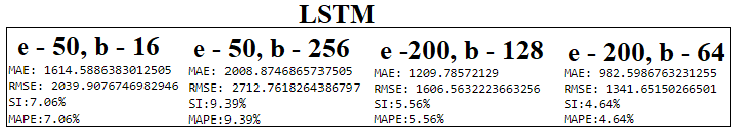

# GRU

In [108]:
regressorGRU = Sequential()
# First GRU layer 
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1, activation='tanh'))
# Compiling the RNN
regressorGRU.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
# Fitting to the training set
historyGRU = regressorGRU.fit(X_train,y_train,epochs=200,batch_size=64)
loss_valuesGRU = history.history['loss']

Epoch 1/200
28/28 [==============================] - 4s 41ms/step - loss: 0.0201
Epoch 2/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0024
Epoch 3/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0019
Epoch 4/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0018
Epoch 5/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0017
Epoch 6/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0016
Epoch 7/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0015
Epoch 8/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0013
Epoch 9/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0015
Epoch 10/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0012
Epoch 11/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 12/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0011
Epoch 13/200
28/28 [=====

28/28 [==============================] - 1s 41ms/step - loss: 3.6004e-04
Epoch 192/200
28/28 [==============================] - 1s 41ms/step - loss: 3.8117e-04
Epoch 193/200
28/28 [==============================] - 1s 40ms/step - loss: 3.6388e-04
Epoch 194/200
28/28 [==============================] - 1s 40ms/step - loss: 4.8245e-04
Epoch 195/200
28/28 [==============================] - 1s 40ms/step - loss: 5.8753e-04
Epoch 196/200
28/28 [==============================] - 1s 40ms/step - loss: 4.5346e-04
Epoch 197/200
28/28 [==============================] - 1s 40ms/step - loss: 3.8637e-04
Epoch 198/200
28/28 [==============================] - 1s 40ms/step - loss: 3.5681e-04
Epoch 199/200
28/28 [==============================] - 1s 42ms/step - loss: 4.0148e-04
Epoch 200/200
28/28 [==============================] - 1s 41ms/step - loss: 4.0080e-04


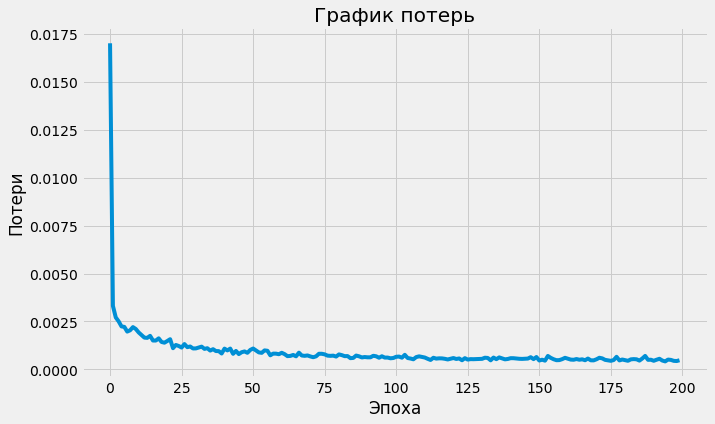

In [109]:
plt.plot(loss_valuesGRU)
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.show()

In [110]:
X_test = []
for i in range(60,560):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

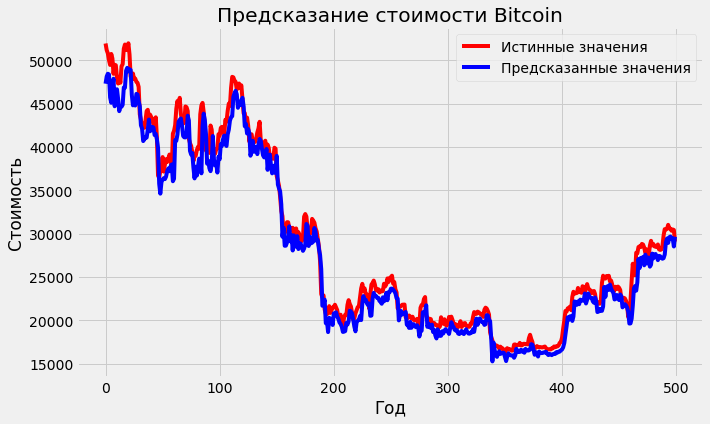

In [111]:
plot_predictions(test_set,GRU_predicted_stock_price)

In [112]:
mae_gru = mean_absolute_error(test_set, GRU_predicted_stock_price)
print('MAE: '+str(mae_gru))
rmse_gru = math.sqrt(mean_squared_error(test_set, GRU_predicted_stock_price))
print('RMSE: '+str(rmse_gru))
si = (rmse_gru/mn)*100
print('SI:' + toFixed(si, 2) + "%")
mape_gru = (np.mean(np.abs(GRU_predicted_stock_price - test_set)/np.abs(test_set)))*100
#print('MAPE: '+str(mape_gru))
print('MAPE:' + toFixed(mape_gru, 2) + "%")

MAE: 1421.6718703212493
RMSE: 1784.5167596599595
SI:6.18%
MAPE:4.95%


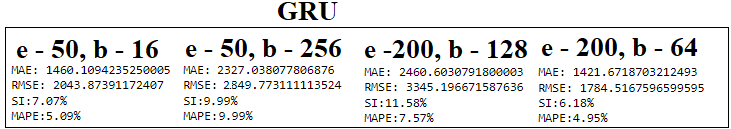